### AdjacecnyMatrix_VoteAgreement

This script retrieves the list of senators and do a one-by-one vote comparison through the API. No actual vote positions are retrieved. The Adjacency Matrix is built and the graph is plotted.
The outputs of the scripts are : linkMatrix.npy, senatorActiveList.npy and AdjacencyMatrix_VoteAgreement.gexf

In [1]:
import json
import os
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from matplotlib import pyplot as plt
import networkx as nx

%matplotlib inline

In [37]:
# Download the list of senators
os.system('curl "https://api.propublica.org/congress/v1/115/senate/members.json" -H "X-API-Key:4ck7hURSgrReOOsMRg0AMXNfaTjj59HGEIF2Mobu" --output senatorList.json')

0

In [11]:
# Parse the json file to a Python List
jsonFile = open('senatorList.json').read()
pythonFile = json.loads(jsonFile)
senatorsList = pythonFile['results'] 
senatorsList = senatorsList[0]
senatorsList = senatorsList["members"]

In [12]:
print(len(senatorsList))

105


In [14]:
# Filter out senators who don't work anymore
senatorActiveList = []
for senator in senatorsList:
    if senator["in_office"]:
        senatorActiveList.append(senator)
nbActiveSenators = len(senatorActiveList)
print(nbActiveSenators)
np.save('senatorActiveList',senatorActiveList)

100


In [10]:
#WARNING : This script takes some time and many requests to the API. Prefer the loading option afterward

#Generate the adjacency matrix based on vote positions

linkMatrix = np.zeros([nbActiveSenators,nbActiveSenators])
for x in range(0,nbActiveSenators): #Go through each line of the adjacency matrix
    senatorX = senatorActiveList[x]
    print(x)
    for y in range(x+1,nbActiveSenators): #Go through each column of the adjacency matrix
        senatorY = senatorActiveList[y]
        
        #Request the vote comparison
        textCommand = 'curl "https://api.propublica.org/congress/v1/members/'+senatorX['id']+'/votes/'+senatorY['id']+'/115/senate.json" -H "X-API-Key:4ck7hURSgrReOOsMRg0AMXNfaTjj59HGEIF2Mobu" --output temp.json'
        os.system(textCommand)
        #Parse the results and extract the agreement score
        jsonFile = open('temp.json').read()
        pythonFile = json.loads(jsonFile)
        score = pythonFile['results'] 
        score = score[0]
        score = score["agree_percent"]
        #Fill the matrix
        linkMatrix[x,y] = score/100
        linkMatrix[y,x] = score/100
#Save the matrix
np.save('linkMatrix',linkMatrix)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


NameError: name 'numpy' is not defined

In [18]:
#Load the saved matrix
linkMatrix = np.load('linkMatrix.npy')
senatorActiveList = np.load('senatorActiveList.npy')

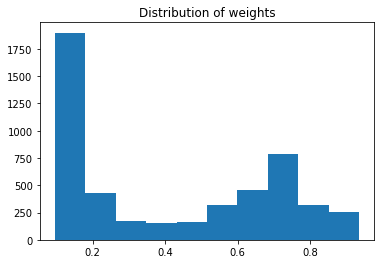

In [4]:
# Extract the distances of the AdjacencyMatrix
distances = squareform(linkMatrix)
# Generate weights (base on tutorial 2b)
kernel_width = distances.mean()
weights = np.exp(-distances**2 / kernel_width**2)
# Look at the weights
plt.hist(weights)
plt.title('Distribution of weights')
plt.show()

In [6]:
#Threshold the adjacency matrix
threshold = 0.5
linkMatrixThreshold = linkMatrix
linkMatrixThreshold[linkMatrixThreshold<threshold]=0
print(linkMatrixThreshold)

[[0.     0.     0.95   ... 0.9769 0.     0.9729]
 [0.     0.     0.     ... 0.     0.8778 0.    ]
 [0.95   0.     0.     ... 0.9632 0.     0.9556]
 ...
 [0.9769 0.     0.9632 ... 0.     0.     0.9852]
 [0.     0.8778 0.     ... 0.     0.     0.    ]
 [0.9729 0.     0.9556 ... 0.9852 0.     0.    ]]


In [7]:
graph = nx.from_numpy_array(linkMatrixThreshold)

C:\Users\agadg\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


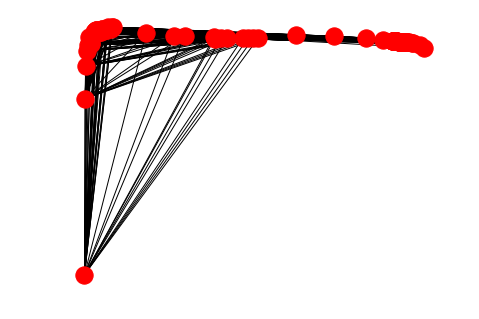

In [8]:
nx.draw_spectral(graph)

C:\Users\agadg\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


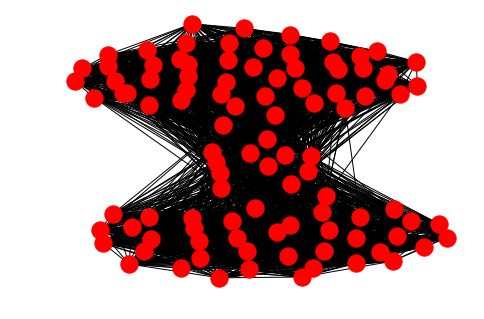

In [9]:
nx.draw_spring(graph)

In [10]:
nx.write_gexf(graph,'AdjacencyMatrix_VoteAgreement.gexf')